In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import autograd.numpy as anp
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime

import json

SEED = 42
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(seed = SEED)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# class MakingDataset(Dataset):
#   def __init__(self, X, y):
#     self.X = X
#     self.y = y

#   def __getitem__(self, index):
#     image = self.X[index]
#     label = self.y[index]
#     return image, label

#   def __len__(self):
#       return len(self.y)

# class TrainTestLoader(object):
#   def __init__(self, dataset="MNIST", feature_reduction='resize', size=256):
#     self.dataset = dataset

#     self.training_data=None
#     self.test_data=None

#     self.train_X = None
#     self.train_y = None
#     self.test_X = None
#     self.test_y = None

#     if dataset == "MNIST":
#       download_root = "./MNIST_DATASET"
#       MNIST_transform = transforms.Compose([
#                     transforms.ToTensor()
#                   ])
#       self.training_data = MNIST(download_root,
#                         train=True,
#                         download=True,
#                         transform=MNIST_transform)

#       self.test_data = MNIST(download_root,
#                         train=False,
#                         download=True,
#                         transform=MNIST_transform)

#       train_X = self.training_data.data / 255.0
#       train_y = self.training_data.targets

#       test_X = self.test_data.data / 255.0
#       test_y = self.test_data.targets

#       # 0과 1에 해당하는 데이터만 추출
#       self.train_X = train_X[(train_y==0) | (train_y==1)]
#       self.train_y = train_y[(train_y==0) | (train_y==1)].numpy()
#       self.test_X = test_X[(test_y==0) | (test_y==1)][:1000]
#       self.test_y = test_y[(test_y==0) | (test_y==1)][:1000].numpy()

#     if dataset == "MNIST" and feature_reduction=='resize':
#       scaling_size = int(np.sqrt(size))
#       t = transforms.Resize(size=(scaling_size, scaling_size))
#       train_X = t(self.train_X)
#       test_X = t(self.test_X)

#       self.train_X = train_X.reshape((train_X.shape[0],
#                                       train_X.shape[1]*train_X.shape[2])).numpy()
#       self.test_X = test_X.reshape((test_X.shape[0],
#                                       test_X.shape[1]*test_X.shape[2])).numpy()
    
#     elif dataset == "MNIST" and feature_reduction=='pca':
#       train_shape = self.train_X.shape
#       test_shape = self.test_X.shape
#       train_X = self.train_X.reshape((train_shape[0],
#                                       train_shape[1]*train_shape[2]))
#       test_X = self.test_X.reshape((test_shape[0],
#                                       test_shape[1]*test_shape[2]))

#       pca = PCA(n_components = size)
#       train_X = pca.fit_transform(train_X)
#       test_X = pca.transform(test_X)
#       self.train_X = train_X
#       self.test_X = test_X

#       if size <= 30:
#         ### Rescale for angle embedding 원본
#         self.train_X = (train_X - train_X.min()) * (np.pi / (train_X.max() - train_X.min()))
#         self.test_X = (test_X - test_X.min()) * (np.pi / (test_X.max() - test_X.min()))



#   def return_dataset(self):
#       return MakingDataset(self.train_X, self.train_y), MakingDataset(self.test_X, self.test_y)


In [ ]:
class TrainTestLoader(object):
  def __init__(self, dataset="MNIST", feature_reduction='resize', size=256):
    self.dataset = dataset

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if dataset == "MNIST":
      download_root = "./MNIST_DATASET"
      MNIST_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = MNIST(download_root,
                        train=True,
                        download=True,
                        transform=MNIST_transform)

      self.test_data = MNIST(download_root,
                        train=False,
                        download=True,
                        transform=MNIST_transform)

      train_X = self.training_data.data / 255.0
      train_y = self.training_data.targets

      test_X = self.test_data.data / 255.0
      test_y = self.test_data.targets

      # 0과 1에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==0) | (train_y==1)]
      self.train_y = train_y[(train_y==0) | (train_y==1)].numpy()
      self.test_X = test_X[(test_y==0) | (test_y==1)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==1)][:1000].numpy()

    if dataset == "MNIST" and feature_reduction=='resize':
      scaling_size = int(np.sqrt(size))
      t = transforms.Resize(size=(scaling_size, scaling_size))
      train_X = t(self.train_X)
      test_X = t(self.test_X)

      self.train_X = train_X.reshape((train_X.shape[0],
                                      train_X.shape[1]*train_X.shape[2])).numpy()
      self.test_X = test_X.reshape((test_X.shape[0],
                                      test_X.shape[1]*test_X.shape[2])).numpy()
    
    elif dataset == "MNIST" and feature_reduction=='pca':
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2]))

      pca = PCA(n_components = size)
      train_X = pca.fit_transform(train_X)
      test_X = pca.transform(test_X)
      self.train_X = train_X
      self.test_X = test_X

      if size <= 30:
        # ### Rescale for angle embedding 원본
        # self.train_X = (train_X - train_X.min()) * (np.pi / (train_X.max() - train_X.min()))
        # self.test_X = (test_X - test_X.min()) * (np.pi / (test_X.max() - test_X.min()))

        #### Rescale for angle embedding 수정
        self.train_X = (train_X - train_X.min(axis = 0))\
                        * (np.pi / (train_X.max(axis = 0) - train_X.min(axis = 0)))
        self.test_X = (test_X - test_X.min(axis = 0)) \
                        * (np.pi / (test_X.max(axis = 0) - test_X.min(axis = 0)))


  def return_dataset(self):
      return self.train_X, self.test_X, self.train_y, self.test_y


In [ ]:
class EmbeddingMethod():
  def __init__(self, n_qubits = 8, embedding_type = "Amplitude"):
    self.n_qubits = n_qubits
    self.embedding_type = embedding_type
  
  def embed_data (self, inputs):
    if self.embedding_type == "Amplitude": # need (2^n_qubits) features
      qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits),
                           pad_with=0, normalize=True)
      
    elif self.embedding_type == 'Angle-compact':
      qml.AngleEmbedding(inputs[:8], wires=range(self.n_qubits), rotation='X')
      qml.AngleEmbedding(inputs[8:16], wires=range(self.n_qubits), rotation='Y')
      
    elif self.embedding_type == "HybridAngle_2":
      N = 3  # 3 classical bits in 2 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      X3 = inputs[2*N:3*N]
      X4 = inputs[3*N:4*N]
      self.Angular_Hybrid_2(X1, wires=[0,1])
      self.Angular_Hybrid_2(X2, wires=[2,3])
      self.Angular_Hybrid_2(X3, wires=[4,5])
      self.Angular_Hybrid_2(X4, wires=[6,7])

    elif self.embedding_type == "HybridAngle_4":
      N = 15 # 15 classical data in 4 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      self.Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
      self.Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])


  # Hybrid Angle Embedding
  
  def Angular_Hybrid_2(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])
  
  def Angular_Hybrid_4(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])



In [ ]:
# Unitary Ansatze for Convolutional Layer

class U_TTN():  # Convolutional circuit 1 - 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    
class U_5(): # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_6():  # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_9():  # 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

class U_13():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])

class U_14():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])

class U_15():  # 4 params
  def __init__(self) -> None:
    self.num_params = 4
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

class U_SO4():  # Convolutional circuit 6 - 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])

class U_SU4(): # Convolutional circuit 9 - 15 params
  def __init__(self) -> None:
    self.num_params = 15
  
  def apply(self, params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


  # Pooling Layer
class Pooling_ansatz1(): #2 params
  def __init__(self) -> None:
      self.num_params = 2
  def apply(self, params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

class Pooling_ansatz2(): #0 params
  def __init__(self) -> None:
    self.num_params = 0
  def apply(self, params, wires):
    qml.CRZ(wires=[wires[0], wires[1]])

class Pooling_ansatz3(): #3 params
  def __init__(self) -> None:
    self.num_params = 3
  def apply(self, *params, wires):
    qml.CRot(*params, wires=[wires[0], wires[1]])



In [ ]:
# Implementation of Quantum Convolutional Neural Network (QCNN) circuit structure.

class QCNN():
  def __init__(self, n_qubits, embedding_type, conv_ansatz, pooling_ansatz):
    super(QCNN, self).__init__()
    self.n_qubits = n_qubits
    self.embedding_method = EmbeddingMethod(n_qubits = n_qubits,
                                            embedding_type = embedding_type)
    if conv_ansatz == "U_TTN":
      self.conv_ansatz = U_TTN()
    elif conv_ansatz == "U_SU4":
      self.conv_ansatz = U_SU4()

    if pooling_ansatz == "Pooling_ansatz1":
      self.pooling_ansatz = Pooling_ansatz1()
    elif pooling_ansatz == "Pooling_ansatz2":
      self.pooling_ansatz = Pooling_ansatz2()
    elif pooling_ansatz == "Pooling_ansatz3":
      self.pooling_ansatz = Pooling_ansatz3()
    ### parameter initialization
    self.params = np.random.randn(self.Calculate_Param_Num(), requires_grad = True)
    
  # Convolutional layers
  def conv_layer1(self, params):
    self.conv_ansatz.apply(params, wires=[0, 7])
    for i in range(0, 8, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
  def conv_layer2(self, params):
    self.conv_ansatz.apply(params, wires=[0, 6])
    self.conv_ansatz.apply(params, wires=[0, 2])
    self.conv_ansatz.apply(params, wires=[4, 6])
    self.conv_ansatz.apply(params, wires=[2, 4])
  def conv_layer3(self, params):
    self.conv_ansatz.apply(params, wires=[0,4])

  # Pooling layers
  def pooling_layer1(self, params):
      for i in range(0, 8, 2):
        self.pooling_ansatz.apply(params, wires=[i + 1, i])
  def pooling_layer2(self, params):
    self.pooling_ansatz.apply(params, wires=[2,0])
    self.pooling_ansatz.apply(params, wires=[6,4])
  def pooling_layer3(self, params):
    self.pooling_ansatz.apply(params, wires=[0,4])


  def QCNN_structure(self, params, X):
    self.embedding_method.embed_data(X)

    ansatz_param_num = self.conv_ansatz.num_params
    pooling_param_num = self.pooling_ansatz.num_params

    param1 = params[0:ansatz_param_num]
    param2 = params[ansatz_param_num: 2 * ansatz_param_num]
    param3 = params[2 * ansatz_param_num: 3 * ansatz_param_num]

    param4 = params[3 * ansatz_param_num :\
                    3 * ansatz_param_num + pooling_param_num]
    param5 = params[3 * ansatz_param_num + pooling_param_num :\
                    3 * ansatz_param_num + 2*pooling_param_num]
    param6 = params[3 * ansatz_param_num + 2*pooling_param_num :\
                    3 * ansatz_param_num + 3*pooling_param_num]

    self.conv_layer1(param1)
    self.pooling_layer1(param4)

    self.conv_layer2(param2)
    self.pooling_layer2(param5)

    self.conv_layer3(param3)
    self.pooling_layer3(param6)


  def QCNN_structure_without_pooling(self, params, X):
    self.embedding_method.embed_data(X)

    ansatz_param_num = self.conv_ansatz.num_params
    param1 = params[0:ansatz_param_num]
    param2 = params[ansatz_param_num: 2 * ansatz_param_num]
    param3 = params[2 * ansatz_param_num: 3 * ansatz_param_num]

    self.conv_layer1(param1)
    self.conv_layer2(param2)
    self.conv_layer3(param3)
  
  def Calculate_Param_Num(self):
    ansatz_param = self.conv_ansatz.num_params
    pooling_param = self.pooling_ansatz.num_params
    total_param_num = ansatz_param*3 + pooling_param*3
    return total_param_num



In [ ]:
class Trainer():
  def __init__(self, setting):
    self.setting = setting
    self.loss_list = []
    self.history_of_parameters = [] ############# 이건 삭제해도 될듯?
    self.total_time = None

  def square_loss(self, labels, predictions):
    loss = 0
    for label, p in zip(labels, predictions):
        loss = loss + (label - p) ** 2

    loss = loss / len(labels)
    return loss

  def cross_entropy(self, labels, predictions):
    loss = 0
    for label, p in zip(labels, predictions):
        c_entropy = label * (anp.log(p[label])) + (1 - label) * anp.log(1 - p[1 - label])
        loss = loss + c_entropy
    return -1 * loss / len(labels)

  def cost(self, params, X, y):
    predictions = [circuit(params, x) for x in X]
    if self.setting.cost_fn == 'mse':
      loss = self.square_loss(y, predictions)
    elif self.setting.cost_fn == 'cross_entropy':
      loss = self.cross_entropy(y, predictions)
    return loss


  def training_model(self, model, train_X, train_y)->None:
    # Optimizer method
    opt = qml.NesterovMomentumOptimizer(stepsize = self.setting.LEARNING_RATE, momentum=0.9)
    start_t = time.time()
    for iter in range(self.setting.train_iter):
      batch_index = np.random.randint(0, len(train_y), (self.setting.BATCH_SIZE,))
      inputs  = train_X[batch_index]
      labels = train_y[batch_index]

      if self.setting.cost_fn == "mse": # label {0,1}을 {1,-1}로 변환
        labels = -2*labels + 1
      elif self.setting.cost_fn == "cross_entropy":
        pass

      model.params, cost_new = opt.step_and_cost(lambda input_params:\
                              self.cost(input_params, inputs, labels), model.params)
      self.history_of_parameters.append(model.params) ###### 이건 삭제해도 될듯?
      self.loss_list.append(cost_new) 
      self.setting.writer.add_scalar('training loss', cost_new, iter)
      np.save(self.setting.filepath+'/'+f'iter{iter}', model.params)
      ### print the cost by each 10 steps
      if (iter+1) % 10 == 0:
          print(f"Iteration {iter+1:>3} loss: {cost_new}")

    end_t = time.time()
    sec = end_t - start_t
    self.total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
    print(f"Training during {self.setting.train_iter} iterations finishes (taken time: {self.total_time}) ")



In [ ]:
class Tester():
  def __init__(self, setting):
    self.setting = setting
    self.accuracy = 0

  def accuracy_test(self, predictions, labels):
    acc = 0
    if self.setting.cost_fn == 'mse':
      # label {0,1}을 {1,-1}로 변환
      labels = -2*labels + 1
      for label, pred in zip(labels, predictions):
        if label*pred > 0: #두 결과의 부호 same
          acc = acc + 1
      self.accuracy = acc / len(labels)

    elif self.setting.cost_fn == 'cross_entropy':
      for label,pred in zip(labels, predictions):
        if pred[0] > pred[1]:
            P = 0
        else:
            P = 1
        if P == label:
            acc = acc + 1
      self.accuracy = acc / len(labels)
  

  def testing_model(self, model, test_X, test_y)->None:
    inputs, labels = test_X, test_y
    predictions = [circuit(model.params, x) for x in inputs]
    self.accuracy_test(predictions, labels)
    print(f"Test socre: {self.accuracy}")



In [ ]:
def saving_summary(setting, trainer, tester):
  with open(setting.filepath+"/"+"summary.json","w") as fp:
    json.dump(dict(
        loss = trainer.loss_list,
        total_time = trainer.total_time,
        accuracy = tester.accuracy
    ), fp = fp)


In [ ]:
class Setting():
  def __init__(self, dataset="MNIST", n_qubits=8, embedding_type="Amplitude",
               feature_reduction = "pca", size = 256, EPOCHS = 3, train_iter = 200,
               BATCH_SIZE = 25, LEARNING_RATE = 0.01,
               conv_ansatz="U_TTN", without_pooling = False,
               pooling_ansatz="Pooling_ansatz1", cost_fn = "mse"):
    self.dataset=dataset
    self.n_qubits=n_qubits
    self.embedding_type = embedding_type
    self.feature_reduction=feature_reduction
    self.size=size
    self.EPOCHS = EPOCHS
    self.train_iter = train_iter
    self.BATCH_SIZE = BATCH_SIZE
    self.LEARNING_RATE = LEARNING_RATE
    self.conv_ansatz=conv_ansatz
    self.without_pooling = without_pooling
    self.pooling_ansatz=pooling_ansatz
    self.cost_fn = cost_fn

    loader = TrainTestLoader(dataset = self.dataset,
                             feature_reduction = self.feature_reduction,
                             size = self.size)
    self.train_X, self.test_X, self.train_y, self.test_y = loader.return_dataset()
    # print data sizes
    print(f"Train set #: {len(self.train_y)}")
    # print(f"Validation set #: {len(validation_set)}")
    print(f"Test set #:  {len(self.test_y)}")

    #######################file path 필요하면 수정######################
    self.filepath = "/content/drive/MyDrive/박경덕교수님연구실/논문QCNN"+\
            f"/{feature_reduction}_{embedding_type}_{conv_ansatz}_{cost_fn}_result"
    
    if os.path.exists(self.filepath) == False:
        os.makedirs(self.filepath)
    self.writer = SummaryWriter(log_dir=self.filepath)
  
  def make_model(self):
    return QCNN(n_qubits = self.n_qubits,
                embedding_type = self.embedding_type,
                conv_ansatz = self.conv_ansatz,
                pooling_ansatz = self.pooling_ansatz)

  def return_train_data(self):
    return self.train_X, self.train_y

  def return_test_data(self):
    return self.test_X, self.test_y



In [ ]:
########################## hyper param ##############################

dataset = "MNIST"
n_qubits = 8
#### "Amplitude" - 256, "Angle-compact"-16, "HybridAngle_2"-12, "HybridAngle_4"-30
embedding_type = 'Angle-compact'
feature_reduction = "pca" #### "pca" or "resize" ####
size = 16
EPOCHS = 3
train_iter = 200
BATCH_SIZE = 25
LEARNING_RATE = 0.01

conv_ansatz = "U_SU4"  #### "U_TTN" (2 params) , "U_SU4" (15 params)
without_pooling = False
pooling_ansatz = "Pooling_ansatz1"  #### "Pooling_ansatz1" "Pooling_ansatz2" "Pooling_ansatz3"
cost_fn = "mse"  #### "mse" or "cross_entropy"

########################## hyper param ##############################


setting = Setting(dataset=dataset,
                  n_qubits=n_qubits,
                  embedding_type = embedding_type,
                  feature_reduction = feature_reduction,
                  size = size,
                  EPOCHS = EPOCHS,
                  train_iter = train_iter,
                  BATCH_SIZE = BATCH_SIZE,
                  LEARNING_RATE = LEARNING_RATE,
                  conv_ansatz=conv_ansatz,
                  without_pooling = without_pooling,
                  pooling_ansatz = pooling_ansatz,
                  cost_fn = cost_fn)

train_X, train_y = setting.return_train_data()
test_X, test_y = setting.return_test_data()

model = setting.make_model()

dev = qml.device('default.qubit', wires = setting.n_qubits)
@qml.qnode(dev)
def circuit(params, X):
  if setting.without_pooling == False:
    model.QCNN_structure(params, X)
  elif setting.without_pooling == True:
    model.QCNN_structure_without_pooling(params, X)

  if cost_fn == 'mse':
    result = qml.expval(qml.PauliZ(4))
  elif cost_fn == 'cross_entropy':
    result = qml.probs(wires=4)
  return result


Train set #: 12665
Test set #:  1000


In [ ]:
start_t = time.time()
random_data = np.random.rand(setting.size)
print(f"result of 1 data: {circuit(model.params, random_data)}")
end_t = time.time()
sec = end_t - start_t
total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
print(total_time)

result of 1 data: -0.3166392602580366
0:00:00


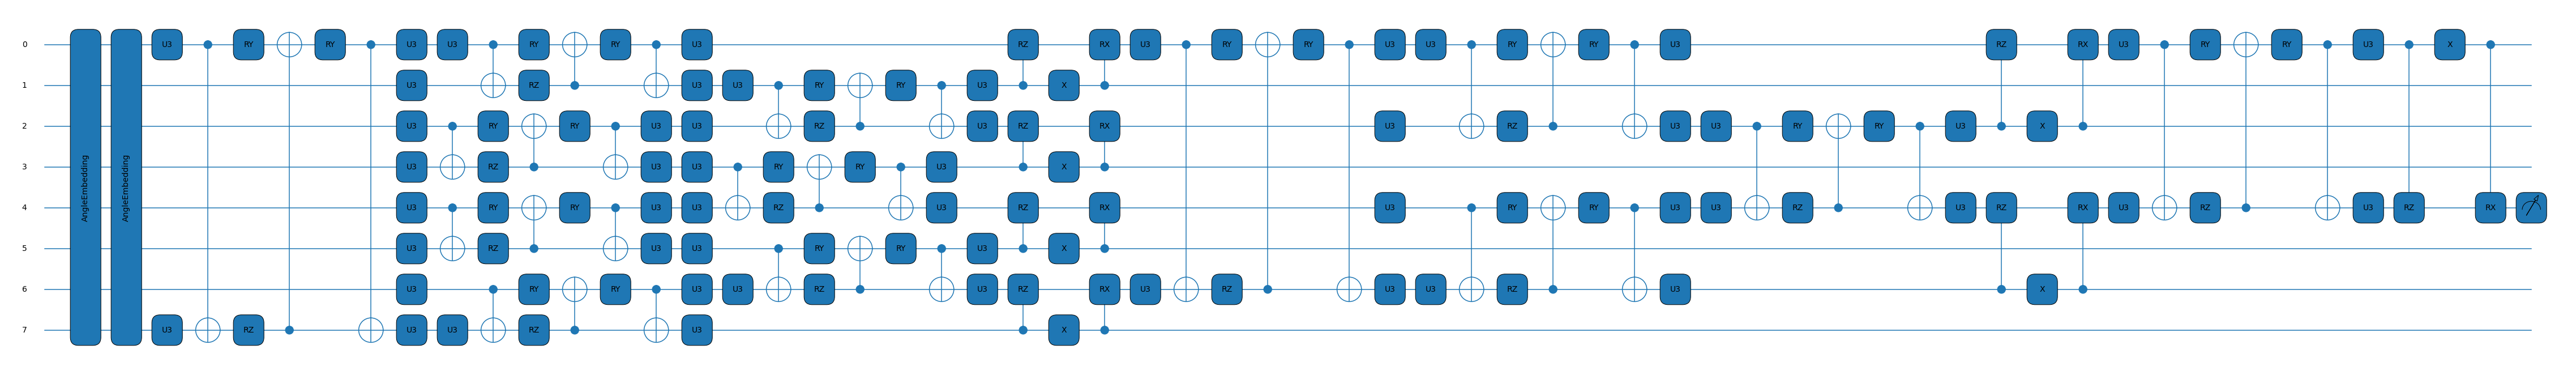

In [ ]:
random_data = np.random.rand(setting.size)
fig, ax = qml.draw_mpl(circuit)(model.params, random_data)
plt.show()

In [ ]:
init_param = model.params
print( init_param )

[-6.18977568e-01 -4.54900668e-01  4.88154265e-01 -5.16048156e-01
  5.46524416e-01  9.52640644e-02 -8.41295831e-02 -1.57275041e+00
 -8.19731356e-01  6.02535366e-01 -6.82021815e-01  1.20536956e+00
  2.34640132e+00  6.56385301e-01  1.49283189e+00  7.20727238e-01
 -5.34262023e-01  2.00151665e-01  2.01332095e+00 -5.23553743e-01
 -1.03932730e+00 -1.13419442e+00 -2.17529384e-01 -1.00347209e+00
  1.67401943e+00  2.16356535e-01  9.71726310e-01 -2.98665391e-01
 -1.14019720e+00 -1.30939395e+00 -9.07991742e-01  3.47525494e-01
  5.19882932e-01  6.03196073e-01 -1.48867268e+00 -4.09185898e-04
 -1.02606183e+00  4.01465968e-01  4.79077055e-01 -1.17217305e+00
  9.68029607e-01  2.33882294e+00  8.34835738e-01 -1.62834040e-01
 -3.16545703e-01 -2.09063982e-01 -7.60733847e-01  2.52398207e-01
 -1.13846259e+00 -1.88969779e+00  2.19601682e-01]


In [ ]:
############ train model ###########

trainer = Trainer(setting = setting)
trainer.training_model(model, train_X, train_y)


/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Iteration  10 loss: 0.7672799922234652
Iteration  20 loss: 0.6228604251004273
Iteration  30 loss: 0.5855650227521679
Iteration  40 loss: 0.4264017006106788
Iteration  50 loss: 0.39663959596225146
Iteration  60 loss: 0.3378786655288193
Iteration  70 loss: 0.31131469742450923
Iteration  80 loss: 0.38425532938630375
Iteration  90 loss: 0.2521920932967856
Iteration 100 loss: 0.2653110228671301
Iteration 110 loss: 0.2199805784935772
Iteration 120 loss: 0.17711567866135935
Iteration 130 loss: 0.21297268057640528
Iteration 140 loss: 0.1838570432613418
Iteration 150 loss: 0.1624697912584461
Iteration 160 loss: 0.15530279089948795
Iteration 170 loss: 0.195801633668846
Iteration 180 loss: 0.20549740916391193
Iteration 190 loss: 0.15903494600897822
Iteration 200 loss: 0.14013537876725757
Training during 200 iterations finishes (taken time: 0:23:14) 


In [ ]:
after_param = model.params
print( after_param )

[-0.46582843  0.01782235  0.65749536 -0.79873494  0.94949914 -0.02346522
 -0.69372744 -1.46199886 -1.48380366  0.43927007 -0.74996685  1.04170855
  2.61800069  0.13673466  1.63802708  0.79659367 -0.10571122  0.05074775
  2.16700264 -0.06954968 -1.42513297 -1.45062456  0.06393455 -0.60823572
  2.04559394  0.35074773  0.62199521 -0.35416591 -0.63632629 -1.02689322
 -0.47693493  0.30581021  0.70218081  0.60359576 -1.70684975 -0.20114715
 -1.42406017  0.19764045  0.64748213 -1.20743124  0.96802961  2.37099035
  1.16396824 -0.2200991  -0.53181187 -0.51812839 -1.16063755 -0.23521104
 -0.55144893 -1.88969779  0.24736321]


In [ ]:
############# test model ###############

tester = Tester(setting = setting)
tester.testing_model(model, test_X, test_y)


Test socre: 0.992


In [ ]:
saving_summary(setting, trainer, tester)

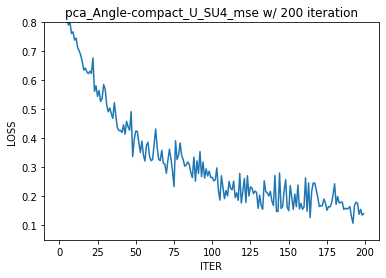

In [ ]:
############### loss plot ################

# loss_list
plt.plot(trainer.loss_list)
plot_title = "_".join(setting.filepath.split("/")[-1].split("_")[:-1])
plt.title(f"{plot_title} w/ {str(setting.train_iter)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.05, 0.8))

plt.show()


In [ ]:
plot_title

'pca_Angle-compact_U_SU4_mse'

In [ ]:
####### tensorboard 실행 #######
!tensorboard --logdir=filepath+"/"